In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# !wget -P data https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet

In [5]:
# !wget -P data https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet 

In [7]:
df = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")
no_of_columns = len(df.columns)
print("Number of columns:", no_of_columns)

Number of columns: 19


In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [9]:
def read_data(file_path):
    df = pd.read_parquet(file_path)
    no_of_columns = len(df.columns)
    print("Number of columns:", no_of_columns)
    df["tpep_pickup_datetime"] = pd.to_datetime(df.tpep_pickup_datetime)
    df["tpep_dropoff_datetime"] = pd.to_datetime(df.tpep_dropoff_datetime)
    df["duration"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"])
    df["duration"] = df.duration.apply(lambda x: x.total_seconds() / 60)
    
    std = np.std(df["duration"])
    print("std:", std)
    before_rows = df.shape[0]
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
    after_rows = df.shape[0]
    fraction = after_rows / before_rows
    print("fraction: ", fraction)
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    return df


In [10]:
train_df = read_data("./data/yellow_tripdata_2023-01.parquet")
val_df = read_data("./data/yellow_tripdata_2023-02.parquet")

Number of columns: 19
std: 42.5943442974141
fraction:  0.9812202822125979
Number of columns: 19
std: 42.84209440985553
fraction:  0.9800944077722545


In [11]:
len(train_df.columns) - 1

19

In [12]:
categorical = ["PULocationID", "DOLocationID"]

In [13]:
train_dicts = train_df[categorical].to_dict(orient="records")
val_dicts = val_df[categorical].to_dict(orient="records")

In [14]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [15]:
X_train.shape

(3009173, 515)

In [16]:
len(dv.feature_names_)

515

In [17]:
target = "duration"
y_train = train_df[target].values
y_val = val_df[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [19]:
def evaluate_model(X, y):
    y_preds = lr.predict(X)
    rmse = root_mean_squared_error(y, y_preds)
    print(rmse)

In [20]:
evaluate_model(X_train, y_train)

7.649262443101424


In [21]:
evaluate_model(X_val, y_val)

7.811813318594438


NameError: name 'y_preds' is not defined

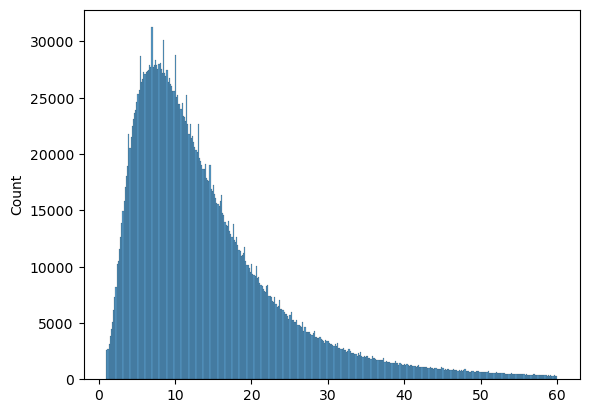

In [22]:
sns.histplot(y_train, label="actual")
sns.histplot(y_preds, label="predicted")
plt.legend()